# Cornell Box + Path Tracing

Numpy implementation of path tracer.

## Numpy Implementation

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [0]:
 def length(p):
  return np.linalg.norm(p, axis=1, keepdims=True)
  
def normalize(p):
  return p/length(p)

In [0]:
def sdSphere(p,radius):
  return length(p) - radius

In [0]:
def udBox(p, b):
  # b = half-widths
  return length(np.maximum(np.abs(p)-b,0.0))

In [0]:
def rotateX(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[:,0,None],p[:,1,None],p[:,2,None]
  return np.concatenate([px,c*py-s*pz,s*py+c*pz],axis=1)

def rotateY(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[:,0,None],p[:,1,None],p[:,2,None]
  return np.concatenate([c*px+s*pz,py,-s*px+c*pz],axis=1)

def rotateZ(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[:,0,None],p[:,1,None],p[:,2,None]
  return np.concatenate([c*px-s*py,s*px+c*py,pz],axis=1)

In [0]:
def opU(a,b):
  # can this be implemented using tf.select?
  # element-wise minimum (id,distance)
  a_smaller = a[:,1] < b[:,1]
  b[a_smaller,:] = a[a_smaller,:]
  return b

In [0]:
def clamp01(v):
  # maybe we should use sigmoid instead of hard thresholding for nicer gradients / soft shadows?
  return np.minimum(np.maximum(v,0.0),1.0)

def relu(a):
  return np.maximum(a,0.)

def dot(a,b):
  return np.sum(a*b,axis=1,keepdims=True)


In [0]:
p = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

In [0]:
length(p)

array([[ 3.74165739],
       [ 8.77496439],
       [13.92838828]])

In [0]:
udBox(p - np.array([[0,3.9,2]]), np.array([[.5,.01,.5]]))

array([[ 2.0179445 ],
       [ 5.06834292],
       [10.06121762]])

In [0]:
import pdb

In [0]:
# Discussion of cosine-weighted importance sampling for Lambertian BRDFs,
# http://www.rorydriscoll.com/2009/01/07/better-sampling/
# and implementation here:
# https://www.shadertoy.com/view/4tl3z4

def sampleCosineWeightedHemisphere(n):
  u1 = np.random.uniform(low=0,high=1,size=(n.shape[0],1))
  u2 = np.random.uniform(low=0,high=1,size=(n.shape[0],1))
  uu = normalize(np.cross(n, np.array([[0.,1.,1.]])))
  vv = np.cross(uu,n)
  ra = np.sqrt(u2)
  rx = ra*np.cos(2*np.pi*u1)
  ry = ra*np.sin(2*np.pi*u1)
  rz = np.sqrt(1.-u2)
  rr = rx*uu+ry*vv+rz*n
  return normalize(rr)

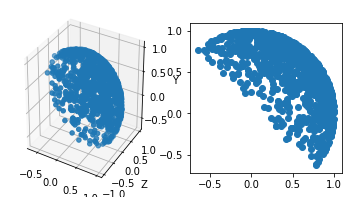

In [0]:
# testing cosine-weighted sphere projection
nor = normalize(np.array([[1.,1.,0.]]))
nor = np.tile(nor,[1000,1])
rd = sampleCosineWeightedHemisphere(nor)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(rd[:,0],rd[:,2],rd[:,1])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_aspect('equal')

ax = fig.add_subplot(122)
ax.scatter(rd[:,0],rd[:,1])
ax.set_aspect('equal')


In [0]:
# object ids

OBJ_NONE=0.0

OBJ_FLOOR=0.1
OBJ_CEIL=.2
OBJ_WALL_RD=.3
OBJ_WALL_WH=.4
OBJ_WALL_GR=.5
OBJ_SHORT_BLOCK=.6
OBJ_TALL_BLOCK=.7
OBJ_LIGHT=1.0

OBJ_SPHERE=0.9

In [0]:
# helper fn for constructing distance fields with object ids
# will be better to refactor this later as its own struct
def df(obj_id, dist):
  d = np.zeros((dist.shape[0],2))
  d[:,0] = obj_id
  d[:,1] = dist.flatten()
  return d

In [0]:
def sdScene(p):
  px,py,pz=p[:,0,None],p[:,1,None],p[:,2,None]
  # floor
  obj_floor = df(OBJ_FLOOR, py) # py = distance from y=0
  res = obj_floor
  
  # sphere
  #obj_sphere = df(OBJ_SPHERE, sdSphere(p-np.array([[0,2.,0.]]),1.0))
  #res=obj_sphere
  #res = opU(res,obj_sphere)
  
  # ceiling
  obj_ceil = df(OBJ_CEIL, 4.-py)
  res = opU(res,obj_ceil)
  
  # backwall
  obj_bwall = df(OBJ_WALL_WH, 4.-pz)
  res = opU(res,obj_bwall)
  
  # leftwall
  obj_lwall = df(OBJ_WALL_RD, px-(-2))
  res = opU(res,obj_lwall)
  
  # rightwall
  obj_rwall = df(OBJ_WALL_GR, 2-px)
  res = opU(res,obj_rwall)

  # light
  obj_light = df(OBJ_LIGHT, udBox(p - np.array([[0,3.9,2]]), np.array([[.5,.01,.5]])))
  res = opU(res,obj_light)
  
  # tall block
  bh = 1.3
  p2 = rotateY(p- np.array([[-.64,bh,2.6]]),.15*np.pi)
  d = udBox(p2, np.array([[.6,bh,.6]]))
  obj_tall_block = df(OBJ_TALL_BLOCK, d)
  res = opU(res,obj_tall_block)  
  
  # short block
  bw = .6
  p2 = rotateY(p- np.array([[.65,bw,1.7]]),-.1*np.pi)
  d = udBox(p2, np.array([[bw,bw,bw]]))
  obj_short_block = df(OBJ_SHORT_BLOCK, d)
  res = opU(res,obj_short_block)
  
  return res

In [0]:
sdScene(p)

array([[5.00000000e-01, 6.88362700e-11],
       [1.00000000e-01, 6.28497254e-11],
       [1.00000000e-01, 5.74367220e-11],
       ...,
       [2.00000000e-01, 5.74367220e-11],
       [2.00000000e-01, 6.28497254e-11],
       [3.00000000e-01, 6.88362700e-11]])

In [0]:
def calcNormal(p):
  # derivative approximation via midpoint rule
  eps = 0.001
  dx=np.array([[eps,0,0]])
  dy=np.array([[0,eps,0]])
  dz=np.array([[0,0,eps]])
  # exactract just the distance component
  nor = np.concatenate([
    sdScene(p+dx)[:,1,None] - sdScene(p-dx)[:,1,None],
    sdScene(p+dy)[:,1,None] - sdScene(p-dy)[:,1,None],
    sdScene(p+dz)[:,1,None] - sdScene(p-dz)[:,1,None],
  ],axis=1)
  return normalize(nor)

In [0]:
MAX_ITERS = 50
HORIZON=20.0

def raymarch(ro,rd):
  # returns df struct (id,t)
  t = 0.0 
  for i in range(MAX_ITERS):
    res = sdScene(ro + t*rd)
    # print(res)
    t += res[:,1,None] # t is (N,1).
  # perform horizon cutoff
  
  res[t[:,0] > HORIZON,0] = OBJ_NONE 
  # zip object id + intersect
  return df(res[:,0],t)

In [0]:
rd = np.array([[0, 0., -1],[0, 0., -1],[0, 0., -1]])
raymarch(p, rd)

ValueError: ignored

In [0]:
# LIGHT_AREA=.2*.2 # 20cm x 20cm light source.
LIGHT_AREA = 1 * 1 # geometery implies 1 meter by 1 meter !! 
# emissive_power = np.array([[0.15, 0.15, 0.15]]) 
emissive_power = np.array([[25., 25., 25.]]) # 25 Watts.
emittedRadiance = emissive_power / np.pi * LIGHT_AREA # Emitted radiance from any direction (Watts / m^2 )
# Lambertian BRDF
lightDiffuseColor = np.array([[.2, .2, .2]]);
leftWallColor = np.array([[.611, .0555, .062]]) * 1.5
rightWallColor = np.array([[.117, .4125, .115]]) * 1.5
whiteWallColor = np.array([[255, 239, 196]]) / 255 # * .8

In [0]:
emittedRadiance

array([[7.95774715, 7.95774715, 7.95774715]])

In [0]:
# # we know what the light normals must be, so we don't need to analytically
# # approximate. Anyways, if we learn the normal field, then
# # this shouldn't be any extra computation.
nor_light = np.array([[0.,-1.,0.]])

In [0]:
def trace(ro,rd,depth,debug=False):
  #print('depth %d, tracing %d rays' % (depth, rd.shape[0]))
  # returns color arriving at ro from rd
  #pdb.set_trace()
  res = raymarch(ro,rd)
  #print('%d null-intersections' % np.sum(res[:,0] == OBJ_NONE))
  
  if debug:
     # visualize id
    return np.tile(res[:,0,None],[1,3])
  
  # assign lambertian brdfs
  brdf = np.zeros((res.shape[0],3))
  brdf[res[:,0] == OBJ_NONE,:] = 0.0
  brdf[res[:,0] == OBJ_CEIL,:] = whiteWallColor
  brdf[res[:,0] == OBJ_FLOOR,:] = whiteWallColor
  brdf[res[:,0] == OBJ_LIGHT,:] = lightDiffuseColor
  brdf[res[:,0] == OBJ_SHORT_BLOCK,:] = whiteWallColor
  brdf[res[:,0] == OBJ_TALL_BLOCK,:] = whiteWallColor
  brdf[res[:,0] == OBJ_WALL_GR,:] = rightWallColor
  brdf[res[:,0] == OBJ_WALL_RD,:] = leftWallColor
  brdf[res[:,0] == OBJ_WALL_WH,:] = whiteWallColor

  t = res[:,1,None]
  p = ro + t*rd
  nor = calcNormal(p)
  
  radiance = np.zeros((ro.shape[0],3))
  
  did_intersect = res[:,0] != OBJ_NONE
  
  # emitted radiance. This is only counted if it's an eye ray, since
  # this contribution is also added in at every bounce.
  
  if depth==0: # is eye ray
    is_light = res[:,0] == OBJ_LIGHT
    Li_e = emittedRadiance
    radiance[is_light,:] += Li_e
  
  #
  # estimate direct area 
  #
  
  # each of the intersect points has some amount of light arriving
  # sample point on area light TODO (ejang) - fix hardcoded light position
  u = .5 * np.random.random(size=(p.shape[0],2))
  p_light = np.zeros((p.shape[0],3))
  p_light[:,0] = np.random.uniform(low=-.5,high=.5,size=(p.shape[0]))
  p_light[:,1] = 3.9
  p_light[:,2] = 2. + np.random.uniform(low=-.5,high=.5,size=(p.shape[0]))

  wi_light = normalize(p_light - p)
  
  res2 = raymarch(p + 0.001 * nor, wi_light)
  # occlusion factor
  vis = res2[:,0] == OBJ_LIGHT
  isect_and_vis = np.logical_and(did_intersect, vis)
  
  # Change of variables from (probability of sampling area) -> 
  # (probability of sampling solid angle) requires division by dw_i/dA.

  # distance from p to light source.
  square_distance = np.sum(np.square(p_light-p), axis=1, keepdims=True)  
  # http://www.pbr-book.org/3ed-2018/Color_and_Radiometry/Working_with_Radiometric_Integrals.html
  pdf_A = 1./LIGHT_AREA
  Li_direct = (emittedRadiance * brdf * 
               relu(dot(nor, wi_light))  *
               relu(dot(nor_light, -wi_light))) / (square_distance * pdf_A)

  #print('Li_direct, current depth=%d' % (depth))
  radiance[isect_and_vis,:] += Li_direct[isect_and_vis,:]

  # return (radiance, p_light, p, emittedRadiance,  brdf, 
  #              relu(dot(nor, wi_light)),
  #              relu(dot(nor_light, -wi_light)), square_distance, pdf_A, isect_and_vis)

  # indirect incoming contribution for intersected points
  # 
  # instead of RR sampling, we just trace for a fixed number of steps
  # to yield a good approximation
  
  if depth < 3:
    # note that ro2, rd2 have fewer items than ro,rd!
    ro2 = p[did_intersect,:] + 0.001 * nor[did_intersect,:] # bump along normal
    rd2 = sampleCosineWeightedHemisphere(nor[did_intersect,:])
    Li_indirect = trace(ro2,rd2,depth+1)
    # doing cosweighted sampling cancels out the geom term
    radiance[did_intersect,:] += brdf[did_intersect,:] * Li_indirect
  
    #print('depth %d max_direct=%f, max_indirect=%f' % (depth, 
    #                                                   np.max(Li_direct[isect_and_vis,:]), 
    #                                                   np.max(Li_indirect)))
  
  return radiance # actually, radiance

In [0]:
# temporary lighting hack
#LIGHT_POS = np.array([[.7,2,-1]])
#LIGHT_POS = np.array([[0,3.,2]])

def render(ro,rd,debug=False):
  # average over many samples of trace in pixel space
  # TODO - the proper thing to do is to handle the colorspace conversion
  # (Radiance -> CIE XYZ -> RGB xform) but let's just do a hack and use
  # a sigmoid
  color = trace(ro,rd,0)
  return color

In [0]:
import time

In [0]:
# render the image
# perspective camera with image plane centered at 0,0,0

N=100 # width of image plane
xs=np.linspace(0,1,N) # 10 pixels
us,vs = np.meshgrid(xs,xs) 
uv = np.vstack([us.flatten(),vs.flatten()]).T # 10x10 image grid
p = np.zeros((N*N,3)) # 
p[:,:2] = -1+2*uv # normalize pixel locations to -1,1

eye = np.tile([0,2.,-3.5],[p.shape[0],1])
look = np.array([[0,2.0,0]]) # look straight ahead
w = normalize(look - eye)

up = np.array([[0,1,0]]) # up axis of world

u = normalize(np.cross(w,up))
v = normalize(np.cross(u,w))

d=2.2 # focal distance
rd = normalize(p[:,0,None]*u + p[:,1,None]*v + d*w)


In [0]:
print('eye')
print(eye[:3])
print('rd')
print(rd[:3])
trace(eye[:3], rd[:3], 0)

eye
[[ 0.   2.  -3.5]
 [ 0.   2.  -3.5]
 [ 0.   2.  -3.5]]
rd
[[ 0.38235956 -0.38235956  0.84119102]
 [ 0.37573526 -0.38348238  0.84366123]
 [ 0.36905287 -0.38459193  0.84610226]]


array([[0.09148579, 0.22563693, 0.06051554],
       [0.39390735, 0.5371033 , 0.30124211],
       [0.38778922, 0.42417649, 0.28810902]])

In [0]:
%%time
img = render(eye,rd,debug=False)

# (radiance, p_light, p, emittedRadiance,  brdf, 
# cos_i, cos_o, square_distance, pdf_A, isect_and_vis) = render(eye, rd, debug=False)


CPU times: user 2.04 s, sys: 334 ms, total: 2.38 s
Wall time: 2.37 s


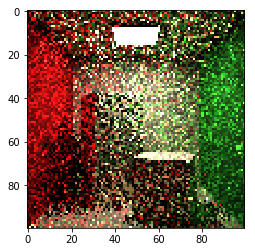

In [0]:
img = np.fliplr(np.flipud(img.reshape((N,N,3))))
plt.imshow(img,interpolation='none',vmin = 0, vmax = 1)
plt.grid('off')
plt.show()

In [0]:
%%time

NUM_SAMPLES=100

for i in range(2,NUM_SAMPLES+1):
  sample = render(eye,rd,debug=False)
  if i % 10 == 0:
    print('Sample %d' % i)
  sample = np.fliplr(np.flipud(sample.reshape((N,N,3))))
  img = (img + sample)

Sample 10
Sample 20
Sample 30
Sample 40
Sample 50
Sample 60
Sample 70
Sample 80
Sample 90
Sample 100
CPU times: user 3min 21s, sys: 23.1 s, total: 3min 44s
Wall time: 3min 45s


8.187263327968568


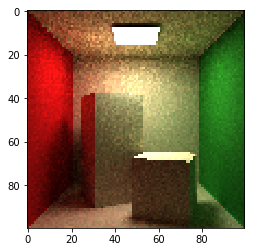

In [0]:
# there are some bugs where the indirect illumination can exceed the direct illumination

img = img/NUM_SAMPLES
print(np.max(img))
plt.imshow(img,interpolation='none',vmin = 0, vmax = 1)
plt.grid('off')